In [3]:
#pip install sinlingua

In [1]:
import os
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import shutil
import sys
import tqdm.notebook as tq
from collections import defaultdict
from sklearn.model_selection import train_test_split

# from sinlingua.preprocessor.stopword_remover import StopWordRemover
# from sinlingua.preprocessor.tokenizer import SinhalaTokenizer
# from sinlingua.preprocessor.stemmer import SinhalaStemmer

import torch
import torch.nn as nn

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd /content/drive/My Drive/research/Data

/content/drive/My Drive/research/Data


In [4]:
df = pd.read_csv('sinhala_df_new.csv')

In [5]:
columns = ['video_title','text','Label','Domain','About']

df = df[columns]

In [6]:
df.iloc[1000:1005]

,video_title,text,Label,Domain,About
1000,අගමැතිගෙන් විශේෂ ප්‍රකාශයක්...,ඔහොම පොත් කියවලා මෙහෙම රට විනාශ කරානම් දාන්වත්...,Negative,P,Ranil
1001,අගමැතිගෙන් විශේෂ ප්‍රකාශයක්...,අපරාදේ එ පොත්පත් ටික,Negative,NaN,NaN
1002,අගමැතිගෙන් විශේෂ ප්‍රකාශයක්...,නව පාලනයකට කැමැත්ත ප්‍රකාශ කර.තම තනතුර භාර දීම...,Negative,P,Ranil
1003,අගමැතිගෙන් විශේෂ ප්‍රකාශයක්...,දරුවන්ට හරි අධ්‍යාපන යක් නෑ. ඔන් ලයින් ක්ලාස් ...,Negative,NaN,NaN
1004,අගමැතිගෙන් විශේෂ ප්‍රකාශයක්...,ඉගෙනගත්තු මිනිහෙකුට කවදාවත් පොතක් පුච්චන්න බෑ....,Negative,NaN,NaN


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12573 entries, 0 to 12572
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   video_title  12307 non-null  object
 1   text         12573 non-null  object
 2   Label        5387 non-null   object
 3   Domain       5621 non-null   object
 4   About        3582 non-null   object
dtypes: object(5)
memory usage: 491.3+ KB


In [8]:
df.shape

(12573, 5)

In [12]:
# df.loc[df['Domain'] == 'Ranil', 'About'] = 'Ranil'
# df.loc[df['Domain'] == 'Government', 'About'] = 'Government'
# df.loc[df['Domain'] == 'Gota', 'About'] = 'Gota'
# df.loc[df['Domain'] == 'Sajith', 'About'] = 'Sajith'
# df.loc[df['Domain'] == 'UNP', 'About'] = 'UNP'
# df.loc[df['Domain'] == 'Mahinda', 'About'] = 'Mahinda'
# df.loc[df['Domain'] == 'NPP', 'About'] = 'NPP'

# Labelled Dataset

In [9]:
df = df[df[['Label', 'Domain', 'About']].apply(lambda row: row.notna().any(), axis=1)]


In [10]:
df.shape

(6500, 5)

# Label 1 (Political / Non Political)

In [11]:
df.Domain.value_counts()

,count
Domain,
P,1793
non,1475
Political,973
p,818
Non,506
Politician,28
political,16
Non-Political,7
Government,2


In [12]:
df['Domain'] = df['Domain'].replace(['P', 'p','Political','Politician','political','Government','rajapaksha',' P'], 'political')
df['Domain'] = df['Domain'].replace(['non','Non','Non ','non ','Non-Political',' non'],'non')

In [13]:
df.Domain.value_counts()

,count
Domain,
political,3631
non,1990


# Label 3 (Political Party / Politician )

In [14]:
df.About.value_counts()

,count
About,
Ranil,552
Prasanna,428
NPP,402
Maithree,234
Other,163
...,...
Rajapakshat,1
sports minister,1
Premadasa,1


In [15]:
df['About'] = df['About'].replace(['Mahinda', 'mahinda','Gotabaya','Gotabhaya','Namal','gootabaya','Mahinda Rajapaksha','Rajapaksha','Rajapakha','Gota','Rajapakshe','rajapaksha','basil & mahinda','bazil','gota','Bazil','pohottuwa','Basil'], 'Rajapaksha')
df['About'] = df['About'].replace(['Government', 'government','government','Goernment','Govenment','Govanment'], 'Government')
df['About'] = df['About'].replace(['Anura','JVP','NPP ','jvp','maalimaawa','anura','npp','maalimawa'], 'NPP')
df['About'] = df['About'].replace(['everyone', 'Everone','Everyone','all','225','everyome'], 'Everyone')
df['About'] = df['About'].replace(['Other', 'shashindra','other','Prasanna','Maithree','Maithripala, Ranil','nalaka','arjuna ranthunga','Neluwe Sumanawansa Thero','Ranjith Maddumabandara','Bimal','Thalatha','muslim politicians','udaya & vimal','sagala rathnayake','Sanath Nishantha','Pohottuwa','Diana','Yahapalanaya','Marikkar','Maithripala','Hareen','Fonseka','namal','sanath nishantha','sarath amunugama','Politicians','FSP','People','Media','sports minister','arjuna ranathunga','tiran','SLTP','Othr','Haleem'], 'Other')
df['About'] = df['About'].replace(['Ranil', 'ranil','ranil & chandrika','Ramil'], 'Ranil')
df['About'] = df['About'].replace(['Sajith', 'ranil','Premadasa','sajith','UNP','SJB','sjb','Saith','Sajith,UNP'], 'Sajith')
df['About'] = df['About'].replace(['Prasanna Ranatunge','mujibur rahman','Mangala','Nalin', '','Galabodawatte Thero','Nalaka','Keheliya','Rohitha','SLPP','sajith','UNP','SJB','Lokuge','Janaka Rathnayake','Mahinda Deshapriya','Susil Premajayantha'], 'Other')
df['About'] = df['About'].replace(['Prasanna Ranatunge','mujibur rahman','Mangala','Nalin','Harsha', 'Dadly','Keheliya Rbukwella','Damitha','Bandara','Wimal','G L Peris','Galabodawatte Thero','Nalaka','Keheliya','Rohitha','SLPP','sajith','UNP','SJB','Lokuge','Janaka Rathnayake','Mahinda Deshapriya','Susil Premajayantha'], 'Other')

In [16]:

df.About.value_counts()

,count
About,
Other,1323
Ranil,562
NPP,493
Everyone,319
Rajapaksha,317
...,...
"Ranil,Sajith",1
SLNP,1
Ranjith bandara,1


# Label 2 (Positive/Negative/Neutral)

In [17]:
df.Label.value_counts()

,count
Label,
Negative,2761
negative,1082
Positive,592
Neutral,466
positive,271
neutral,136
postive,14
Positve,11
negative,10


In [18]:
df['Label'] = df['Label'].replace(['Negative', 'negative','Negative ','negative ','negartive','Negativve','negaitve','Negatuve','negarive','ngative','negaive',], 'negative')
df['Label'] = df['Label'].replace(['Positive ', 'positive','postive','Positve','positve','Positive','Positiive','Poaitive'], 'positive')
df['Label'] = df['Label'].replace(['Neutral ', 'neutral','Netural','Neutal','neutal','Neutral'], 'neutral')


In [19]:
df.Label.value_counts()

,count
Label,
negative,3877
positive,897
neutral,613


# Multi Class classification for label 3

In [20]:
df = df.dropna(subset=['About'])

In [21]:
df.shape

(3582, 5)

In [22]:
df.About.value_counts().head(10)

,count
About,
Other,1323
Ranil,562
NPP,493
Everyone,319
Rajapaksha,317
Sajith,261
Government,231
Thilanga Sumathipala,7
Kabir,5


In [23]:
df_ranil = df[df['About'] == 'Ranil'].sample(n = 261, random_state = 88)
df_other = df[df['About'] == 'Other'].sample(n = 261, random_state = 88)
df_every = df[df['About'] == 'Everyone'].sample(n = 261, random_state = 88)
df_rajapaksha = df[df['About'] == 'Rajapaksha'].sample(n = 261, random_state = 88)
df_npp = df[df['About'] == 'NPP'].sample(n = 261, random_state = 88)
df_sajith = df[df['About'] == 'Sajith'].sample(n = 261, random_state = 88)

In [24]:
df = pd.concat([df_ranil, df_other,df_every,df_rajapaksha,df_sajith,df_npp])

In [25]:
df.head()

,video_title,text,Label,Domain,About
11803,සංඝ රත්නයෙන් අවසර නොගෙන හලීම් කළ කතාව,පොන්නයෝ ඉන්න තෙක් තම්බියෝ රජ කරයි...අමනයාගේගේ ...,negative,political,Ranil
12069,මම ගැන බොරු බයක් ජනතාව තුළ ඇති කරලා... ගෝඨාභය,Mona boruda meka කියන්න හදන්නේ ? Meya hethagen...,negative,political,Ranil
12048,ජනපති දුන් දුරකථන ඇමතුම ගැන අගමැති කරුණු හෙළි ...,ඔය මහා මුසලයව් තෝවෛ ගෝල්ඩ් peace ගෙනිහිල්ල රජ...,negative,political,Ranil
1039,අගමැතිගෙන් විශේෂ ප්‍රකාශයක්...,බයිලා එපා ඔයා යන්න වේන්න ඔනා ඒක විතරයි,negative,political,Ranil
1186,අගමැතිගෙන් විශේෂ ප්‍රකාශයක්...,පුස්තකාලය ගිණි තිබිබද? තමුන්ම ගිණි තියාගත්තද? ...,negative,political,Ranil


In [26]:


from sklearn.utils import shuffle

df = shuffle(df)


In [27]:
df.head()

,video_title,text,Label,Domain,About
11549,මගී ජනතාව ගොඩක් මතක් කළේ මගේ මෑණියන්ව - ජනපති,පල පල ගෝත හුකන්න,negative,political,Other
12078,ගෝඨාභය ජනපති වුණාම ආණ්ඩුවේ ගැටුමක් නෑ... එස්.බී.,ජයවේවා,positive,political,Rajapaksha
5488,ප්‍රසන්න පොහොට්ටුව හැර යයිද ? | Hiru News | Hi...,මාලිමාවට හා සියළුම ශ්‍රී ලාංකිකයින්ට ජයවේවා ❤️🇱🇰❤,positive,political,NPP
11662,ගෝඨාභය ආරක්ෂක ලේකම් නෙමෙයි - බිමල්,"A,K,D අරලියා කෙලිය දිවුල",negative,political,NPP
11224,"චීස්, යෝගට් කටුගෙට යයි - එක ඩොලර් එකක් එවන්නේ ...",නියමයි ස්තුතියි රාජපක්ෂලා. රට නැත්තටම නැතිකරපු...,negative,political,Rajapaksha


# One Hot Encoding for About column

In [28]:
labels_onehot = pd.get_dummies(df['About'])

# Ensure indices match before concatenation
df = df.reset_index(drop=True)
labels_onehot = labels_onehot.reset_index(drop=True)
labels_onehot = labels_onehot.astype(int)

# Concatenate the DataFrames
df = pd.concat([df, labels_onehot], axis=1)


In [29]:
df.head()

,video_title,text,Label,Domain,About,Everyone,NPP,Other,Rajapaksha,Ranil,Sajith
0,මගී ජනතාව ගොඩක් මතක් කළේ මගේ මෑණියන්ව - ජනපති,පල පල ගෝත හුකන්න,negative,political,Other,0,0,1,0,0,0
1,ගෝඨාභය ජනපති වුණාම ආණ්ඩුවේ ගැටුමක් නෑ... එස්.බී.,ජයවේවා,positive,political,Rajapaksha,0,0,0,1,0,0
2,ප්‍රසන්න පොහොට්ටුව හැර යයිද ? | Hiru News | Hi...,මාලිමාවට හා සියළුම ශ්‍රී ලාංකිකයින්ට ජයවේවා ❤️🇱🇰❤,positive,political,NPP,0,1,0,0,0,0
3,ගෝඨාභය ආරක්ෂක ලේකම් නෙමෙයි - බිමල්,"A,K,D අරලියා කෙලිය දිවුල",negative,political,NPP,0,1,0,0,0,0
4,"චීස්, යෝගට් කටුගෙට යයි - එක ඩොලර් එකක් එවන්නේ ...",නියමයි ස්තුතියි රාජපක්ෂලා. රට නැත්තටම නැතිකරපු...,negative,political,Rajapaksha,0,0,0,1,0,0


In [30]:
df.isna().sum()

,0
video_title,26
text,0
Label,1
Domain,0
About,0
Everyone,0
NPP,0
Other,0
Rajapaksha,0
Ranil,0


In [31]:
df['text'] = df['video_title'] + '.' + df['text']
df.drop(columns=['video_title','Label','Domain','About'], axis = 1, inplace=True)

# Remove Emoticons


In [32]:
import re

def remove_emoji(string):
    if isinstance(string, str): # Check if the input is a string
        emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               "]+", flags=re.UNICODE)
        return emoji_pattern.sub(r'', string)
    else:
        return string # Return the original value if it's not a string

df['text'] = df['text'].apply(remove_emoji)

# Remove URLs

In [33]:
import re

def remove_urls(text):
  if isinstance(text, str): # Check if the input is a string
    return re.sub(r'''(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'".,<>?«»“”‘’]))''', " ", text)
  else:
    return text # Return the original value if it's not a string

# Apply the function to the text column
df['text'] = df['text'].apply(remove_urls)

# Data Cleaning

In [34]:
import re

def clean_data(text):
    if isinstance(text, str): # Check if the input is a string
        text = re.sub(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', text) # Remove URLs

        text = re.sub(r'<.*?>', '', text)     # Remove HTML tags

        text = re.sub(r'@\\w+', '', text)  # Remove mentions

        text = re.sub(r'[^\u0D80-\u0DFF\s]', ' ', text) # Remove non-Sinhala characters (punctuation, numbers, etc.)
        return text
    else:
        return text # Return the original value if it's not a string

df['text'] = df['text'].apply(clean_data)

In [35]:
df.shape

(1566, 7)

# Train, Test, Valid Split (70:15:15)





In [36]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Further split the test data into validation and test sets
test_df, valid_df = train_test_split(test_df, test_size=0.5, random_state=42)

print(f"Train data shape: {train_df.shape}")
print(f"Test data shape: {test_df.shape}")
print(f"Valid data shape: {valid_df.shape}")


Train data shape: (1252, 7)
Test data shape: (157, 7)
Valid data shape: (157, 7)


In [37]:
# Hyperparameters
MAX_LEN = 100
TRAIN_BATCH_SIZE = 32
VALID_BATCH_SIZE = 32
TEST_BATCH_SIZE = 32
EPOCHS = 30
LEARNING_RATE = 1e-05

In [38]:
from transformers import AutoTokenizer, RobertaModel

import torch
tokenizer = AutoTokenizer.from_pretrained("AshenR/AshenBERTo")



/usr/local/lib/python3.10/dist-packages/torch_xla/__init__.py:202: UserWarning: `tensorflow` can conflict with `torch-xla`. Prefer `tensorflow-cpu` when using PyTorch/XLA. To silence this warning, `pip uninstall -y tensorflow && pip install tensorflow-cpu`. If you are in a notebook environment such as Colab or Kaggle, restart your notebook runtime afterwards.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/1.23k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/437k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/307k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/958 [00:00<?, ?B/s]

In [39]:
# from transformers import AutoTokenizer, AutoModelForMaskedLM
# tokenizer = AutoTokenizer.from_pretrained("NLPC-UOM/SinBERT-small")


In [40]:
import numpy as np

# Get all contents from df.text
contents = [content for content in df.text]

max_content_len = 0
content_len = []

# Iterate over the contents list
for content in contents:
    # Check if the content is a string
    if isinstance(content, str):
        content_len.append(len(content.split()))
        max_content_len = max(len(content.split()), max_content_len)

print('Number of contents:', len(contents))
print('Max length of the contents:', max_content_len)
print('Mean length of the contents:', np.mean(content_len))

Number of contents: 1566
Max length of the contents: 440
Mean length of the contents: 24.683766233766235


In [41]:
# Test the tokenizer
test_text = "We are testing BERT tokenizer."
# generate encodings
encodings = tokenizer.encode_plus(test_text,
                                  add_special_tokens = True,
                                  max_length = 100,
                                  truncation = True,
                                  padding = "max_length",
                                  return_attention_mask = True,
                                  return_tensors = "pt")

In [42]:
encodings

{'input_ids': tensor([[    0,    59,    73,  3684,  6525,   929,   225,    38,    41,    54,
            56,  1327, 12635, 14412,    18,     2,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0

In [43]:
df['text']

,text
0,මගී ජනතාව ගොඩක් මතක් කළේ මගේ මෑණියන්ව ජනපති ...
1,ගෝඨාභය ජනපති වුණාම ආණ්ඩුවේ ගැටුමක් නෑ එස් බ...
2,ප් රසන්න පොහොට්ටුව හැර යයිද ...
3,ගෝඨාභය ආරක්ෂක ලේකම් නෙමෙයි බිමල් අරලිය...
4,චීස් යෝගට් කටුගෙට යයි එක ඩොලර් එකක් එවන්නේ ...
...,...
1561,තවත් පුළුවන් තරම් සහන දෙනවා බැසිල් ඖෂධ මිල...
1562,සජිත්ට ලැබෙන ඡන්ද ගාණ නාලක හරියටම කියයි ...
1563,ප් රසන්න පොහොට්ටුව හැර යයිද ...
1564,අවුරුදු කන්න ඉන්දියාවෙන් කෑම බැසිල්ගේ අලුත්ම...


In [44]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from tqdm import tqdm
from sklearn.metrics import accuracy_score
from torch.utils.data import Dataset

In [45]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, df, tokenizer, max_len, target_list):
        self.tokenizer = tokenizer
        self.df = df
        self.title = list(df['text'])
        self.targets = self.df[target_list].values
        self.max_len = max_len

    def __len__(self):
        return len(self.title)

    def __getitem__(self, index):
        title = str(self.title[index])
        title = " ".join(title.split())
        inputs = self.tokenizer.encode_plus(
            title,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_token_type_ids=True,
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        return {
            'input_ids': inputs['input_ids'].flatten(),
            'attention_mask': inputs['attention_mask'].flatten(),
            'token_type_ids': inputs["token_type_ids"].flatten(),
            'targets': torch.FloatTensor(self.targets[index]),
            'title': title
        }

In [46]:
target_list = ['Ranil', 'Other', 'Everyone', 'Rajapaksha', 'Sajith','NPP']
target_list

['Ranil', 'Other', 'Everyone', 'Rajapaksha', 'Sajith', 'NPP']

In [47]:
train_dataset = CustomDataset(train_df, tokenizer, MAX_LEN, target_list)
valid_dataset = CustomDataset(valid_df, tokenizer, MAX_LEN, target_list)
test_dataset = CustomDataset(test_df, tokenizer, MAX_LEN, target_list)

In [48]:
# testing the dataset
next(iter(train_dataset))

{'input_ids': tensor([    0,   306,   294,  3851,  3881,   317,   272,   292,   265,   348,
           368,   264,   630,   600,   268,   267, 17038,   264,   630,   285,
           294,   279,   294,   280,   264,   280,   272,   267,   277,   451,
           264,   280,   265,   339,   739,   275,   284,   292,     2,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1]),
 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 

In [49]:
# Data loaders
train_data_loader = torch.utils.data.DataLoader(train_dataset,
    batch_size=TRAIN_BATCH_SIZE,
    shuffle=True,
    num_workers=4,
    pin_memory=True
)

val_data_loader = torch.utils.data.DataLoader(valid_dataset,
    batch_size=VALID_BATCH_SIZE,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

test_data_loader = torch.utils.data.DataLoader(test_dataset,
    batch_size=TEST_BATCH_SIZE,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

In [50]:

from transformers import AutoModelForSequenceClassification
class BERTClass(torch.nn.Module):
    def __init__(self):
        super(BERTClass, self).__init__()
        self.bert_model = AutoModelForSequenceClassification.from_pretrained('AshenR/AshenBERTo', num_labels=6)
        #self.bert_model = BertModel.from_pretrained('bert-base-uncased', return_dict=True)
        self.dropout = torch.nn.Dropout(0.2)
        self.softmax = torch.nn.Softmax(dim=1)

    def forward(self, input_ids, attn_mask, token_type_ids):
        output = self.bert_model(

            input_ids,
            attention_mask=attn_mask,
            token_type_ids=token_type_ids
        )
        logits = output.logits
        output_dropout = self.dropout(logits)
        output = self.softmax(output_dropout)  # Apply softmax
        return output

model = BERTClass()

config.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/236M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at AshenR/AshenBERTo and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [51]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

BERTClass(
  (bert_model): RobertaForSequenceClassification(
    (roberta): RobertaModel(
      (embeddings): RobertaEmbeddings(
        (word_embeddings): Embedding(20000, 768, padding_idx=1)
        (position_embeddings): Embedding(514, 768, padding_idx=1)
        (token_type_embeddings): Embedding(1, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): RobertaEncoder(
        (layer): ModuleList(
          (0-5): 6 x RobertaLayer(
            (attention): RobertaAttention(
              (self): RobertaSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): RobertaSelfOutput(
                (dense): L

In [52]:
def loss_fn(outputs, targets):
    return torch.nn.BCEWithLogitsLoss()(outputs, targets)


In [53]:
from transformers import AdamW

# define the optimizer
optimizer = AdamW(model.parameters(), lr = 5e-6)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [54]:
# Training of the model
def train_model(training_loader, model, optimizer):

    losses = []
    correct_predictions = 0
    num_samples = 0
    # set model to training mode (activate droput, batch norm)
    model.train()
    # initialize the progress bar
    loop = tq.tqdm(enumerate(training_loader), total=len(training_loader),
                      leave=True, colour='steelblue')
    for batch_idx, data in loop:
        ids = data['input_ids'].to(device, dtype = torch.long)
        mask = data['attention_mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.float)

        # forward
        outputs = model(ids, mask, token_type_ids) # (batch,predict)=(32,8)
        loss = loss_fn(outputs, targets)
        losses.append(loss.item())
        # training accuracy
        _, preds = torch.max(outputs, dim=1) # batch dim
        _, targ = torch.max(targets, dim=1)  # batch dim
        num_samples += len(targ)  # technically adding batch size
        correct_predictions += torch.sum(preds == targ)

        # backward
        optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        # grad descent step
        optimizer.step()

        # Update progress bar
        #loop.set_description(f"")
        #loop.set_postfix(batch_loss=loss)

    # returning: trained model, model accuracy, mean loss
    return model, float(correct_predictions)/num_samples, np.mean(losses)

In [55]:
def eval_model(validation_loader, model, optimizer):
    losses = []
    correct_predictions = 0
    num_samples = 0
    # set model to eval mode (turn off dropout, fix batch norm)
    model.eval()

    with torch.no_grad():
        for batch_idx, data in enumerate(validation_loader, 0):
            ids = data['input_ids'].to(device, dtype = torch.long)
            mask = data['attention_mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.float)
            outputs = model(ids, mask, token_type_ids)

            loss = loss_fn(outputs, targets)
            losses.append(loss.item())

            # validation accuracy
            _, preds = torch.max(outputs, dim=1) # batch dim
            _, targ = torch.max(targets, dim=1)  # batch dim
            num_samples += len(targ)  # technically adding batch size
            correct_predictions += torch.sum(preds == targ)

    return float(correct_predictions)/num_samples, np.mean(losses)

# Model Training

In [56]:
import os
from collections import defaultdict
import torch

data_dir = "/content/drive/My Drive/research/Data/"
history = defaultdict(list)
best_accuracy = 0

for epoch in range(1, EPOCHS+1):
    print(f'Epoch {epoch}/{EPOCHS}')

    # Train model
    model, train_acc, train_loss = train_model(train_data_loader, model, optimizer)

    # Evaluate model
    val_acc, val_loss = eval_model(val_data_loader, model,optimizer)

    print(f'train_loss={train_loss:.4f}, val_loss={val_loss:.4f} train_acc={train_acc:.4f}, val_acc={val_acc:.4f}')

    # Record history
    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)

    # Save the best model
    if val_acc > best_accuracy:
        torch.save(model.state_dict(), os.path.join(data_dir, "best_model_state.bin"))
        best_accuracy = val_acc


Epoch 1/30


  0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.7515, val_loss=0.7497 train_acc=0.2244, val_acc=0.3503
Epoch 2/30


  0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.7488, val_loss=0.7456 train_acc=0.3474, val_acc=0.4331
Epoch 3/30


  0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.7440, val_loss=0.7382 train_acc=0.3866, val_acc=0.4713
Epoch 4/30


  0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.7377, val_loss=0.7279 train_acc=0.4401, val_acc=0.5287
Epoch 5/30


  0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.7305, val_loss=0.7188 train_acc=0.4840, val_acc=0.5541
Epoch 6/30


  0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.7215, val_loss=0.7117 train_acc=0.5192, val_acc=0.5860
Epoch 7/30


  0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.7158, val_loss=0.7062 train_acc=0.5367, val_acc=0.6051
Epoch 8/30


  0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.7121, val_loss=0.7012 train_acc=0.5663, val_acc=0.6306
Epoch 9/30


  0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.7079, val_loss=0.6963 train_acc=0.5990, val_acc=0.6879
Epoch 10/30


  0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.7038, val_loss=0.6917 train_acc=0.6070, val_acc=0.6879
Epoch 11/30


  0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.6975, val_loss=0.6872 train_acc=0.6342, val_acc=0.7006
Epoch 12/30


  0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.6952, val_loss=0.6837 train_acc=0.6526, val_acc=0.7197
Epoch 13/30


  0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.6920, val_loss=0.6815 train_acc=0.6589, val_acc=0.7006
Epoch 14/30


  0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.6885, val_loss=0.6797 train_acc=0.6837, val_acc=0.7134
Epoch 15/30


  0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.6866, val_loss=0.6787 train_acc=0.7133, val_acc=0.7197
Epoch 16/30


  0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.6847, val_loss=0.6770 train_acc=0.6997, val_acc=0.7261
Epoch 17/30


  0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.6819, val_loss=0.6757 train_acc=0.7228, val_acc=0.7389
Epoch 18/30


  0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.6812, val_loss=0.6755 train_acc=0.7165, val_acc=0.7389
Epoch 19/30


  0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.6810, val_loss=0.6748 train_acc=0.7181, val_acc=0.7452
Epoch 20/30


  0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.6775, val_loss=0.6743 train_acc=0.7420, val_acc=0.7516
Epoch 21/30


  0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.6770, val_loss=0.6745 train_acc=0.7580, val_acc=0.7516
Epoch 22/30


  0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.6744, val_loss=0.6726 train_acc=0.7588, val_acc=0.7643
Epoch 23/30


  0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.6739, val_loss=0.6727 train_acc=0.7612, val_acc=0.7643
Epoch 24/30


  0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.6735, val_loss=0.6730 train_acc=0.7620, val_acc=0.7580
Epoch 25/30


  0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.6708, val_loss=0.6722 train_acc=0.7931, val_acc=0.7643
Epoch 26/30


  0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.6695, val_loss=0.6719 train_acc=0.7827, val_acc=0.7452
Epoch 27/30


  0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.6676, val_loss=0.6705 train_acc=0.7995, val_acc=0.7707
Epoch 28/30


  0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.6696, val_loss=0.6704 train_acc=0.7843, val_acc=0.7707
Epoch 29/30


  0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.6673, val_loss=0.6721 train_acc=0.8099, val_acc=0.7516
Epoch 30/30


  0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.6664, val_loss=0.6710 train_acc=0.8083, val_acc=0.7516


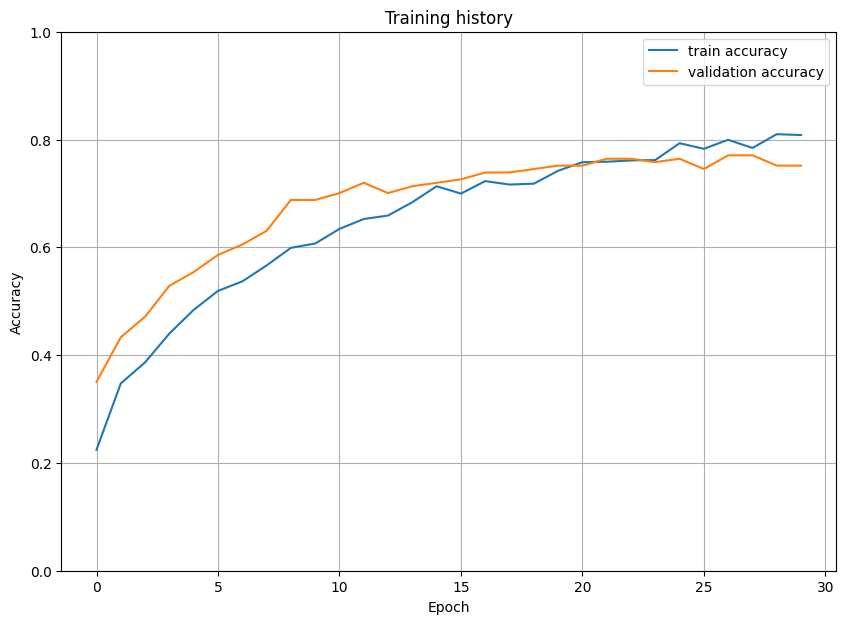

In [57]:
plt.rcParams["figure.figsize"] = (10,7)
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);
plt.grid()

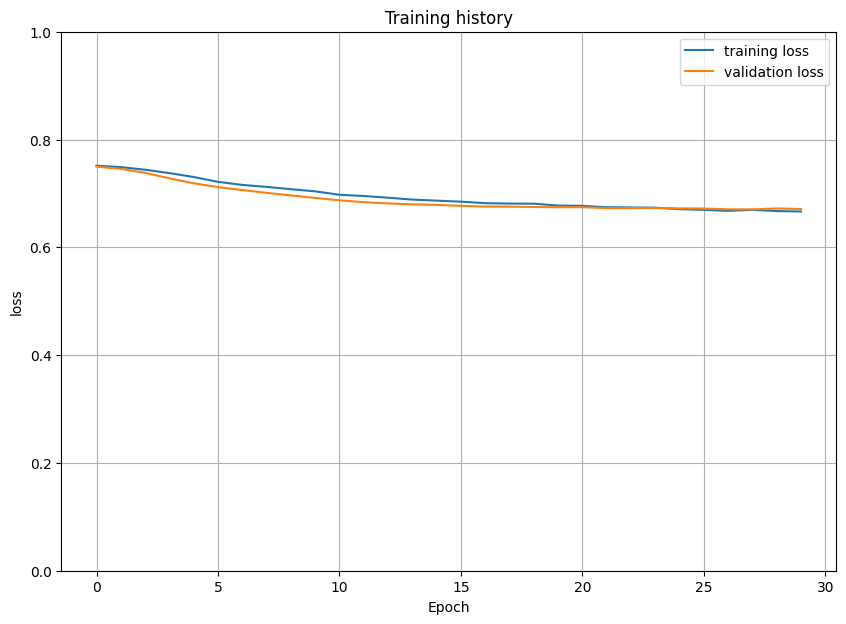

In [58]:
plt.rcParams["figure.figsize"] = (10,7)
plt.plot(history['train_loss'], label='training loss')
plt.plot(history['val_loss'], label='validation loss')
plt.title('Training history')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);
plt.grid()

# Evaluate the model

In [63]:
model = BERTClass()
model.to(device)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at AshenR/AshenBERTo and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BERTClass(
  (bert_model): RobertaForSequenceClassification(
    (roberta): RobertaModel(
      (embeddings): RobertaEmbeddings(
        (word_embeddings): Embedding(20000, 768, padding_idx=1)
        (position_embeddings): Embedding(514, 768, padding_idx=1)
        (token_type_embeddings): Embedding(1, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): RobertaEncoder(
        (layer): ModuleList(
          (0-5): 6 x RobertaLayer(
            (attention): RobertaAttention(
              (self): RobertaSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): RobertaSelfOutput(
                (dense): L

# Evaluate the model using the test data

In [59]:
test_acc,test_loss = eval_model(test_data_loader,model,optimizer)

In [60]:
test_acc

0.7070063694267515

In [61]:
test_loss

0.6791297197341919

In [62]:
from sklearn.metrics import confusion_matrix, classification_report # Correct the module name to 'metrics'

In [63]:
def get_predictions(model, data_loader):
    model = model.eval()

    titles = []
    predictions = []
    prediction_probs = []
    target_values = []

    with torch.no_grad():
      for data in data_loader:
        title = data["title"]
        ids = data["input_ids"].to(device, dtype = torch.long)
        mask = data["attention_mask"].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data["targets"].to(device, dtype = torch.float)

        outputs = model(ids, mask, token_type_ids)
        _, preds = torch.max(outputs, dim=1)
        _, targ = torch.max(targets, dim=1)

        titles.extend(title)
        predictions.extend(preds)
        prediction_probs.extend(outputs)
        target_values.extend(targ)

    predictions = torch.stack(predictions).cpu()
    prediction_probs = torch.stack(prediction_probs).cpu()
    target_values = torch.stack(target_values).cpu()

    return titles, predictions, prediction_probs, target_values

In [64]:
titles, predictions, prediction_probs, target_values = get_predictions(model, test_data_loader)

In [65]:
print(classification_report(target_values, predictions, target_names=target_list))

              precision    recall  f1-score   support

       Ranil       0.77      0.89      0.83        19
       Other       0.64      0.62      0.63        29
    Everyone       0.64      0.80      0.71        20
  Rajapaksha       0.71      0.71      0.71        34
      Sajith       0.72      0.78      0.75        27
         NPP       0.79      0.54      0.64        28

    accuracy                           0.71       157
   macro avg       0.71      0.72      0.71       157
weighted avg       0.71      0.71      0.70       157



In [66]:
import seaborn as sns
def show_confusion_matrix(confusion_matrix):
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
    plt.ylabel('True category')
    plt.xlabel('Predicted category')

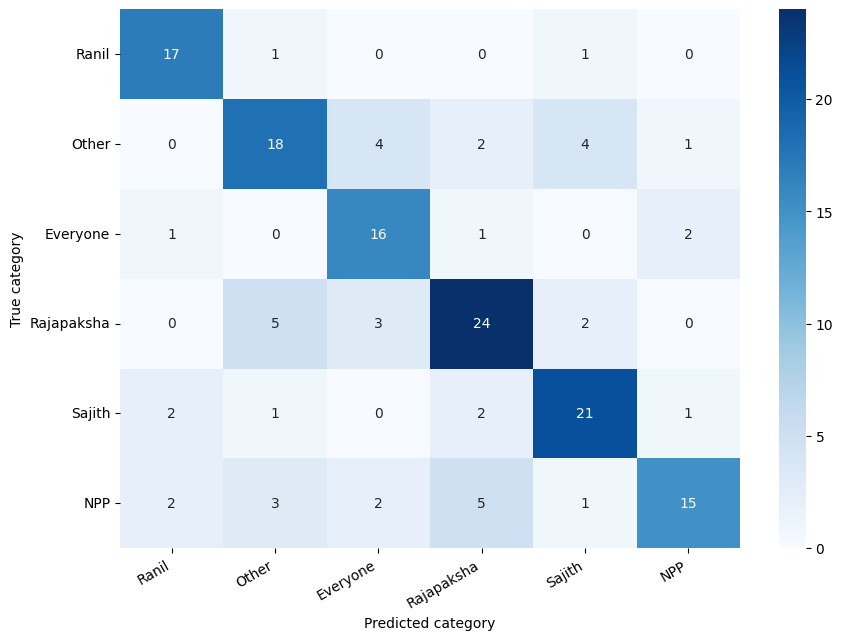

In [67]:
plt.rcParams["figure.figsize"] = (10,7)
cm = confusion_matrix(target_values, predictions)
df_cm = pd.DataFrame(cm, index=target_list, columns=target_list)
show_confusion_matrix(df_cm)

In [68]:
test_df = pd.DataFrame(list(zip(titles, target_values, predictions)))

In [69]:
test_df

,0,1,2
0,නඩු තීන්දුව ගැන අහන්න එපා කතෝලික සභාවෙන් සමාව ...,tensor(1),tensor(1)
1,කෘත් යාධිකාරී මණ්ඩලයේ පුරප්පාඩු පිරවීමේ වැඩපිළ...,tensor(4),tensor(4)
2,ප් රසන්න පොහොට්ටුව හැර යයිද චන්දෙ තියපන්කො පෙන...,tensor(5),tensor(1)
3,ය ගත්ත වැරදි දේශපාලන තීන්දු මැතිවරණය කල් ගියොත...,tensor(4),tensor(4)
4,ජනාධිපතිවරණය ගාල්ල දිස්ත් රික්කය තැපැල් ඡන්ද ප...,tensor(3),tensor(3)
...,...,...,...
152,ආණ්ඩුව ඇතුලෙම තවත් කැරැල්ලක් මැති ඇමතිලා ක් සු...,tensor(1),tensor(3)
153,හිරු රාත් රී ප් රධාන ප් රවෘත්ති විකාශය හොරු හො...,tensor(3),tensor(4)
154,විශ් රාම වැටුප් අහෝසිය ගැන ඔක්කොම ගොළුයි අනුර ...,tensor(5),tensor(5)
155,ය ගත්ත වැරදි දේශපාලන තීන්දු මැතිවරණය කල් ගියොත...,tensor(4),tensor(4)


In [74]:
test_df.to_csv("test.csv",index=False)

In [70]:
raw_text = "රාජපක්ෂ උන් තමයි ඒවා කලේ අහිංසක මිනිස්සු නෙවෙයි"

In [71]:
encoded_text = tokenizer.encode_plus(
    raw_text,
    max_length=MAX_LEN,
    add_special_tokens=True,
    return_token_type_ids=True,
    pad_to_max_length=True,
    return_attention_mask=True,
    return_tensors='pt',
)


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2870: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [72]:
input_ids = encoded_text['input_ids'].to(device)
attention_mask = encoded_text['attention_mask'].to(device)
token_type_ids = encoded_text['token_type_ids'].to(device)
output = model(input_ids, attention_mask, token_type_ids)
_, prediction = torch.max(output, dim=1)

In [73]:
print(f'Title: {raw_text}')
print(f'Category: {target_list[prediction]}')

Title: රාජපක්ෂ උන් තමයි ඒවා කලේ අහිංසක මිනිස්සු නෙවෙයි
Category: Other


In [74]:
raw_text = "රනිල් මහත්තයෝ බොරැ පමිපෝරි ගහන්න එපා කරැණාකරලා දැන්වත් අයින්වෙන්න. කටනිසානේ මාළුවත් නැහුනේ. යන්න කියපුවහම ගියානමි ඔය පුශ්ණ මොකුත් වෙන්නේනැහැනේ"
print(f'Title: {raw_text}')
print(f'Category: {target_list[prediction]}')

Title: රනිල් මහත්තයෝ බොරැ පමිපෝරි ගහන්න එපා කරැණාකරලා දැන්වත් අයින්වෙන්න. කටනිසානේ මාළුවත් නැහුනේ. යන්න කියපුවහම ගියානමි ඔය පුශ්ණ මොකුත් වෙන්නේනැහැනේ
Category: Other


In [76]:
raw_text = "අගමැතිගෙන් විශේෂ ප්‍රකාශයක්....අපේ වල අපිම කපාගන්නා අසමත් ජාතියක් අපි යකෝ මේ වැටිච්ච වලෙන් රට මාසෙකින් ගොඩදාන්න රනිල්ට තියා වයිමටවත් පුලුවන්ද පතුලක් නොපෙනෙන අඳුරු ආගාධයකට රාජපක්ෂ හැතිකරේ මේ මුතු ඇටේ ඇදල දැම්මෙ එතරම්ම බංකොලොත් වෙච්ච රටක් ආර්ථිකය නැවත පනගන්නන්න බාරගත්තු අභියෝගයම මදිද රනිල්ට තව ටික දවසක් දෙන්න තිබ්බ කලබල උනා වැඩියි ගොඩක් අපි ඇන්දුනා වැඩියි කොහොමත් රනිල්ට යමක් කරන්න කාලයක් දෙන්නෙම නැහැ මේ පලවෙනි වතාව නෙවෙයි චන්ද් රිකාත් එක්ක පරිවාස ගහල රනිල්ව පුටුවෙන් බැස්සුව මතකද රනිල් අවුරුදු පහක් හයක් හිටියොත් කයිවාරුකාරයින්ට ඇඩ් රස් නැහැ රට ගොඩදැම්මොත් උන් ඉවරයි සත් ය එයයි රනිල්ට ගහයි ගෙවල් ගිනිතියයි ඒත් රනිල්ගෙ පෞරුෂය මෛත් රී නෝනගෙ නිහතමානීත්වය හමුවේ අපි ලිලිපුට්ටො බං හැමදේම නැතිවෙනව විනාශවෙනව කියල ඔබතුමා හොඳින්ම දන්නව ගේ දොර ඉඩකඩම් යානවාහන සැප සම්පත් තනතුරු තාන්නමාන්න මේ සියලු දේ වගේම ජීවිතයද අස්ථිර අවිනිශ්චිත තාවකාලික බව දහමින් ඔබ තේරුම් ගෙන තියෙනව බියගුලු අමනුෂ තිරිසන් ක් රියා හමුවේ ඔබසතු ආත්ම ශක්තිය ආත්ම විශ්වාසය බිඳකින්වත් අඩු නොවනබවත් අපි දන්නව ඉවසන් ඉමු"
print(f'Title: {raw_text}')
print(f'Category: {target_list[prediction]}')

Title: අගමැතිගෙන් විශේෂ ප්‍රකාශයක්....අපේ වල අපිම කපාගන්නා අසමත් ජාතියක් අපි යකෝ මේ වැටිච්ච වලෙන් රට මාසෙකින් ගොඩදාන්න රනිල්ට තියා වයිමටවත් පුලුවන්ද පතුලක් නොපෙනෙන අඳුරු ආගාධයකට රාජපක්ෂ හැතිකරේ මේ මුතු ඇටේ ඇදල දැම්මෙ එතරම්ම බංකොලොත් වෙච්ච රටක් ආර්ථිකය නැවත පනගන්නන්න බාරගත්තු අභියෝගයම මදිද රනිල්ට තව ටික දවසක් දෙන්න තිබ්බ කලබල උනා වැඩියි ගොඩක් අපි ඇන්දුනා වැඩියි කොහොමත් රනිල්ට යමක් කරන්න කාලයක් දෙන්නෙම නැහැ මේ පලවෙනි වතාව නෙවෙයි චන්ද් රිකාත් එක්ක පරිවාස ගහල රනිල්ව පුටුවෙන් බැස්සුව මතකද රනිල් අවුරුදු පහක් හයක් හිටියොත් කයිවාරුකාරයින්ට ඇඩ් රස් නැහැ රට ගොඩදැම්මොත් උන් ඉවරයි සත් ය එයයි රනිල්ට ගහයි ගෙවල් ගිනිතියයි ඒත් රනිල්ගෙ පෞරුෂය මෛත් රී නෝනගෙ නිහතමානීත්වය හමුවේ අපි ලිලිපුට්ටො බං හැමදේම නැතිවෙනව විනාශවෙනව කියල ඔබතුමා හොඳින්ම දන්නව ගේ දොර ඉඩකඩම් යානවාහන සැප සම්පත් තනතුරු තාන්නමාන්න මේ සියලු දේ වගේම ජීවිතයද අස්ථිර අවිනිශ්චිත තාවකාලික බව දහමින් ඔබ තේරුම් ගෙන තියෙනව බියගුලු අමනුෂ තිරිසන් ක් රියා හමුවේ ඔබසතු ආත්ම ශක්තිය ආත්ම විශ්වාසය බිඳකින්වත් අඩු නොවනබවත් අපි දන්නව ඉවසන් ඉමු
Category: Other


In [81]:
df_new = pd.read_csv("df_annotated.csv")

FileNotFoundError: [Errno 2] No such file or directory: 'df_annotated.csv'

In [ ]:
#Load the saved model
model_path = 'model_best.pth'
model = torch.load(model_path)

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("NLPC-UOM/SinBERT-small")

In [ ]:
# Tokenize the dataset
def tokenize_function(sentences):
    return tokenizer(sentences, padding=True, truncation=True, max_length = 256,return_tensors="pt")

tokenized_data = df_new['text'].apply(tokenize_function)

In [ ]:
model.eval()

# Use the model

In [ ]:
import pandas as pd
#from transformers import BertTokenizer

In [ ]:
pip install openpyxl

In [ ]:
df = pd.read_excel('to_label.xlsx')

In [ ]:
df.head()

In [ ]:
df['Combined'] = df['video_title'] + '.' + df['text']


In [ ]:
df.head()

In [ ]:
def remove_emoji(text):
    if isinstance(text, str):  # Check if text is a string
        emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               "]+", flags=re.UNICODE)
        return emoji_pattern.sub(r'', text)
    else:
        return text

df['Combined'] = df['Combined'].apply(remove_emoji)

In [ ]:
def remove_urls(text):
  if isinstance(text, str):  # Check if text is a string
    return re.sub(r'''(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'".,<>?«»“”‘’]))''', " ", text)
  else:
    return text
# Apply the function to the text column
df['Combined'] = df['Combined'].apply(remove_urls)

In [ ]:
def clean_data(text):
    if isinstance(text, str): # Check if text is a string
        text = re.sub(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', text) # Remove URLs

        text = re.sub(r'<.*?>', '', text)     # Remove HTML tags

        text = re.sub(r'@\\w+', '', text)  # Remove mentions

        text = re.sub(r'[^\u0D80-\u0DFF\s]', ' ', text) # Remove non-Sinhala characters (punctuation, numbers, etc.)
        return text
    else:
        return ''

df['Combined'] = df['Combined'].apply(clean_data)

In [ ]:
model_path = 'model_best.pth'
model = torch.load(model_path)
model.eval()

In [ ]:
def preprocess_text(text):
    encoding = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=128,  # Adjust this based on your max token length during training
        padding='max_length',
        truncation=True,
        return_tensors='pt'
    )
    return encoding['input_ids'], encoding['attention_mask']

df['input_ids'], df['attention_mask'] = zip(*df['Combined'].map(preprocess_text))


In [ ]:
from torch.utils.data import Dataset, DataLoader

class TextDataset(Dataset):
    def __init__(self, df):
        # Extract the tensors from the lists and squeeze to remove extra dimensions
        self.input_ids = torch.stack(df['input_ids'].tolist()).squeeze(1)
        self.attention_mask = torch.stack(df['attention_mask'].tolist()).squeeze(1)

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return {
            'input_ids': self.input_ids[idx],
            'attention_mask': self.attention_mask[idx]
        }

dataset = TextDataset(df)
dataloader = DataLoader(dataset, batch_size=32, shuffle=False)  # Adjust batch size as needed


In [ ]:
labels = []

with torch.no_grad():
    for batch in dataloader:
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        # Assuming your tokenizer generates 'token_type_ids'
        token_type_ids = batch.get('token_type_ids', None)  # Get token_type_ids if available, else None

        outputs = model(input_ids=input_ids, attn_mask=attention_mask, token_type_ids=token_type_ids)  # Pass all required arguments
        # The model outputs logits directly
        logits = outputs
        predictions = torch.argmax(logits, dim=1)
        labels.extend(predictions.cpu().numpy())

df['About'] = labels

In [ ]:
df.head()

In [ ]:
label_mapping = {
    0: 'Everyone',
    1: 'NPP',
    2: 'Rajapaksha',
    3: 'Ranil',
    4: 'Sajith'
}

# Convert numerical labels to categories
df['category'] = df['About'].map(label_mapping)


In [ ]:
df.head()

In [ ]:
df = df.drop(columns=['input_ids', 'attention_mask'])


In [ ]:
df.to_csv('About_predicted.csv', index=False)